# 🎵 Music Genre Classification

This notebook implements a multi-class music genre classifier using the GTZAN dataset.

## Approaches:
1. **Tabular ML** - Using pre-extracted audio features (MFCCs, spectral features, etc.)
2. **CNN** - Using mel spectrogram images
3. **Transfer Learning** - Using pre-trained models on spectrograms

## Dataset:
- 10 genres: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock
- 100 tracks per genre (30 seconds each)
- Pre-extracted features in CSV format
- Mel spectrogram images (PNG)

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(
    "andradaolteanu/gtzan-dataset-music-genre-classification",'Data')

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification/Data


## 1. Setup & Imports

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path

# Preprocessing & ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)

# ML Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ Libraries imported successfully!
TensorFlow version: 2.19.0
GPU available: False


In [28]:
%ls '/kaggle/input/gtzan-dataset-music-genre-classification/Data'

features_30_sec.csv  features_3_sec.csv  genres_original/  images_original/


## 2. Data Loading & Exploration

In [29]:
# Define paths
DATA_DIR = Path('/kaggle/input/gtzan-dataset-music-genre-classification/Data')
FEATURES_30_SEC = DATA_DIR / 'features_30_sec.csv'
FEATURES_3_SEC = DATA_DIR / 'features_3_sec.csv'
IMAGES_DIR = DATA_DIR / 'images_original'
AUDIO_DIR = DATA_DIR / 'genres_original'

# Load tabular data
df_30 = pd.read_csv(FEATURES_30_SEC)
df_3 = pd.read_csv(FEATURES_3_SEC)

print("=" * 60)
print("📊 Dataset Overview")
print("=" * 60)
print(f"\n30-second features: {df_30.shape[0]} samples, {df_30.shape[1]} columns")
print(f"3-second features: {df_3.shape[0]} samples, {df_3.shape[1]} columns")
print(f"\nGenres: {df_30['label'].unique().tolist()}")
print(f"Number of genres: {df_30['label'].nunique()}")

📊 Dataset Overview

30-second features: 1000 samples, 60 columns
3-second features: 9990 samples, 60 columns

Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Number of genres: 10


In [30]:
# Display sample data
print("\n📋 Sample Data (30-second features):")
df_30.head()


📋 Sample Data (30-second features):


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [31]:
# Data info
print("\n📊 Data Types & Info:")
print(df_30.dtypes.value_counts())
print(f"\n Missing values: {df_30.isnull().sum().sum()}")


📊 Data Types & Info:
float64    57
object      2
int64       1
Name: count, dtype: int64

 Missing values: 0


In [32]:
# Statistical summary
print("\n📈 Statistical Summary:")
df_30.describe().T.head(20)


📈 Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
length,1000.0,6.620308e+05,1.784074e+03,6.600000e+05,661504.000000,6.617940e+05,6.617940e+05,6.758080e+05
chroma_stft_mean,1000.0,3.786817e-01,8.170489e-02,1.719392e-01,0.319562,3.831479e-01,4.359417e-01,6.636847e-01
chroma_stft_var,1000.0,8.633982e-02,7.735298e-03,4.455525e-02,0.082298,8.661463e-02,9.125551e-02,1.081115e-01
rms_mean,1000.0,1.309297e-01,6.568311e-02,5.276444e-03,0.086657,1.224431e-01,1.756822e-01,3.979734e-01
rms_var,1000.0,3.051399e-03,3.634500e-03,4.294372e-06,0.000942,1.816440e-03,3.577055e-03,2.767948e-02
spectral_centroid_mean,1000.0,2.201781e+03,7.159606e+02,5.700404e+02,1627.697311,2.209263e+03,2.691295e+03,4.435244e+03
spectral_centroid_var,1000.0,4.696916e+05,4.008995e+05,7.911251e+03,184350.530174,3.384862e+05,6.121479e+05,3.036843e+06
spectral_bandwidth_mean,1000.0,2.242541e+03,5.263165e+02,8.980662e+02,1907.240605,2.221393e+03,2.578470e+03,3.509646e+03
spectral_bandwidth_var,1000.0,1.370792e+05,9.645567e+04,1.078719e+04,67376.554428,1.119775e+05,1.823716e+05,6.947848e+05
rolloff_mean,1000.0,4.571549e+03,1.574792e+03,7.491406e+02,3380.069642,4.658524e+03,5.533810e+03,8.677673e+03


### 2.1 Class Distribution

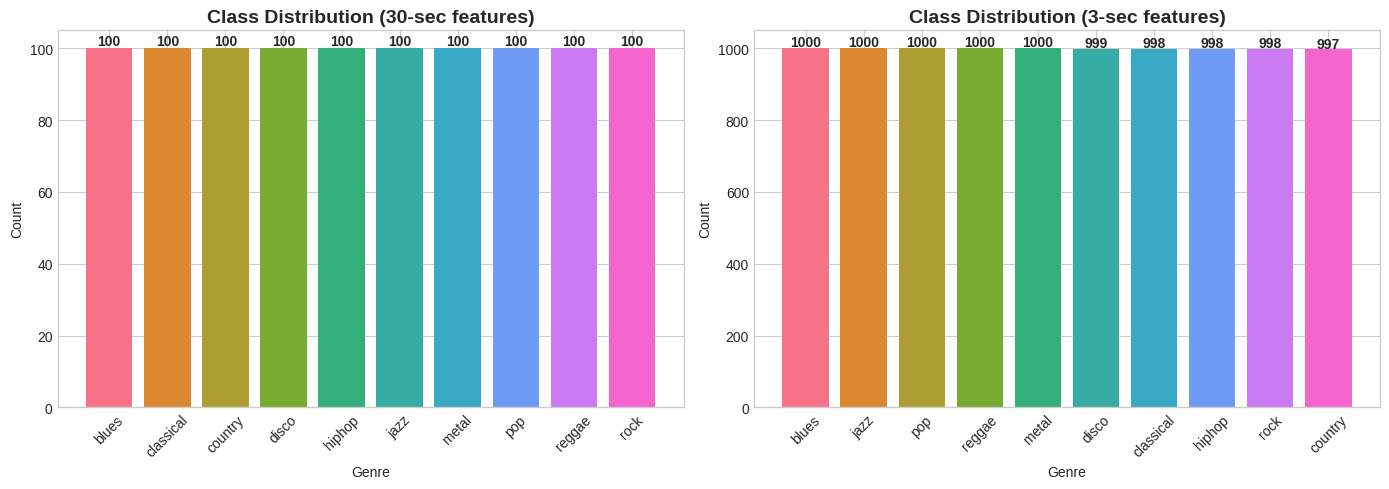


✅ Dataset is perfectly balanced with 100 samples per genre (30-sec)
✅ 3-sec dataset has ~999 samples per genre (10 segments per track)


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 30-second data distribution
genre_colors = sns.color_palette('husl', n_colors=10)
genre_counts_30 = df_30['label'].value_counts()
axes[0].bar(genre_counts_30.index, genre_counts_30.values, color=genre_colors)
axes[0].set_title('Class Distribution (30-sec features)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(genre_counts_30.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 3-second data distribution
genre_counts_3 = df_3['label'].value_counts()
axes[1].bar(genre_counts_3.index, genre_counts_3.values, color=genre_colors)
axes[1].set_title('Class Distribution (3-sec features)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(genre_counts_3.values):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Dataset is perfectly balanced with 100 samples per genre (30-sec)")
print("✅ 3-sec dataset has ~999 samples per genre (10 segments per track)")

### 2.2 Feature Correlation Analysis

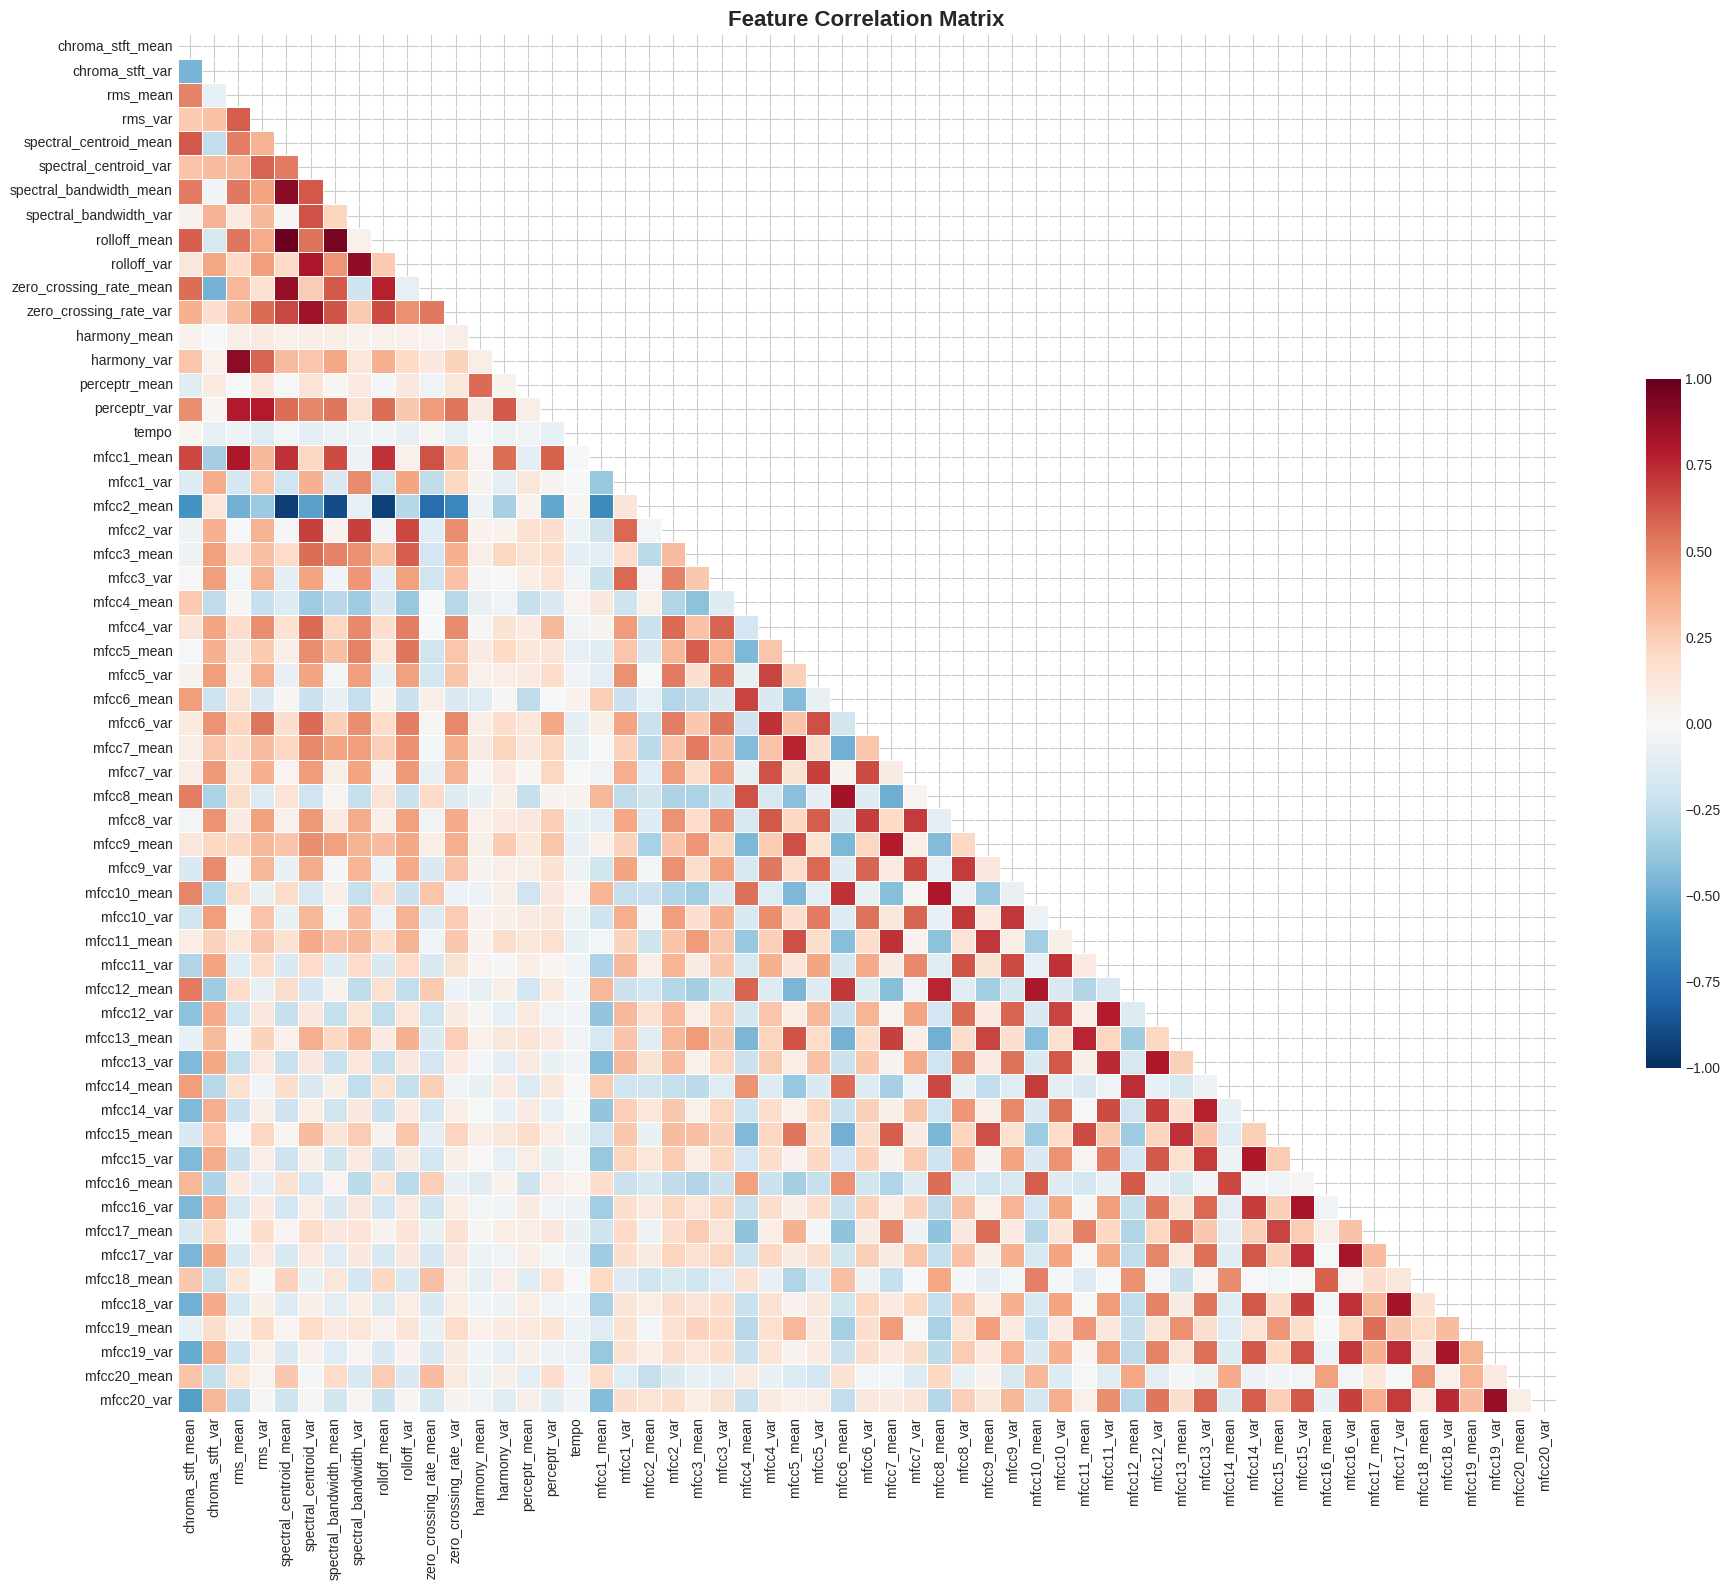

In [34]:
# Select numeric features for correlation analysis
numeric_cols = df_30.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('length')  # Remove constant column

# Compute correlation matrix
corr_matrix = df_30[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.3 MFCC Feature Analysis

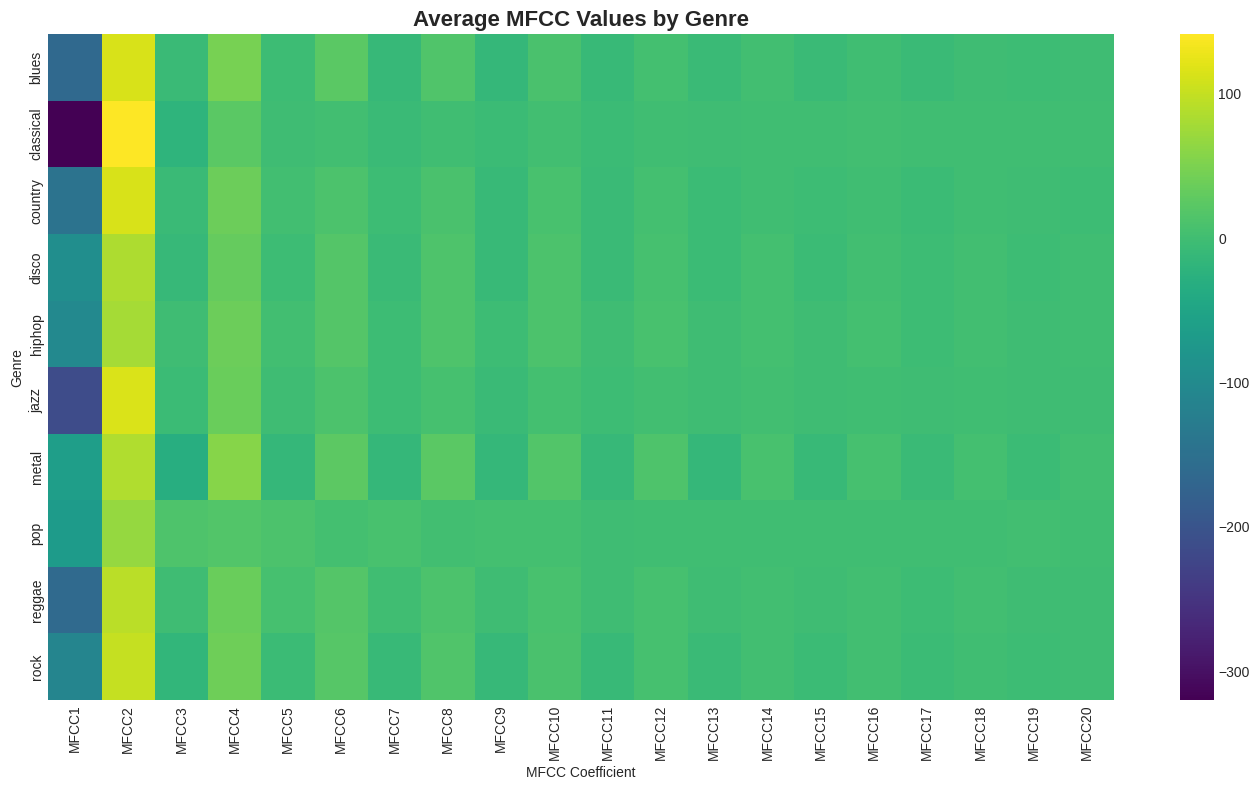

In [35]:
# Extract MFCC means for each genre
mfcc_cols = [f'mfcc{i}_mean' for i in range(1, 21)]
genres = df_30['label'].unique()

# Create MFCC profile for each genre
mfcc_profiles = pd.DataFrame()
for genre in genres:
    genre_data = df_30[df_30['label'] == genre][mfcc_cols].mean()
    mfcc_profiles[genre] = genre_data

# Plot MFCC heatmap by genre
plt.figure(figsize=(14, 8))
sns.heatmap(mfcc_profiles.T, cmap='viridis', annot=False,
            xticklabels=[f'MFCC{i}' for i in range(1, 21)],
            yticklabels=genres)
plt.title('Average MFCC Values by Genre', fontsize=16, fontweight='bold')
plt.xlabel('MFCC Coefficient')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

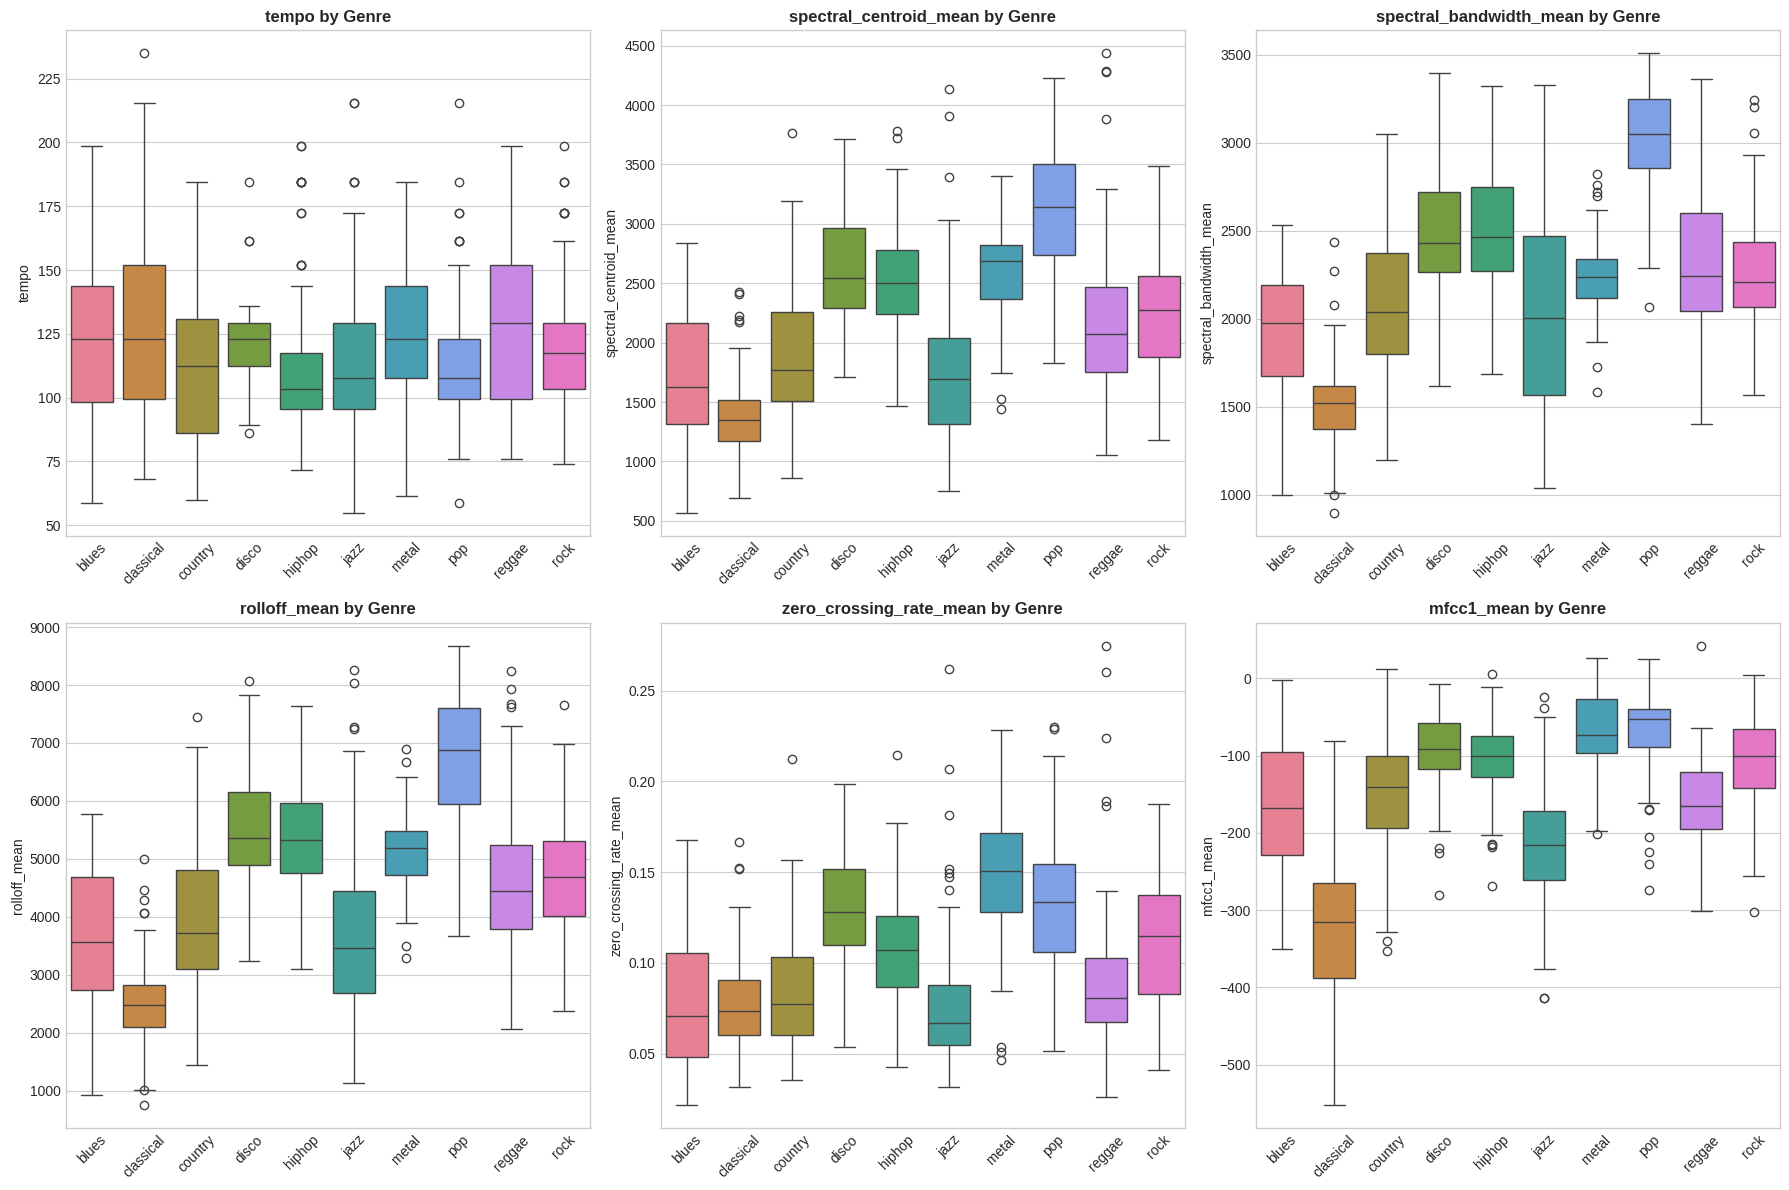

In [36]:
# Box plots for key features by genre
key_features = ['tempo', 'spectral_centroid_mean', 'spectral_bandwidth_mean',
                'rolloff_mean', 'zero_crossing_rate_mean', 'mfcc1_mean']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(x='label', y=feature, data=df_30, ax=axes[i], palette='husl')
    axes[i].set_title(f'{feature} by Genre', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2.4 Spectrogram Images Preview

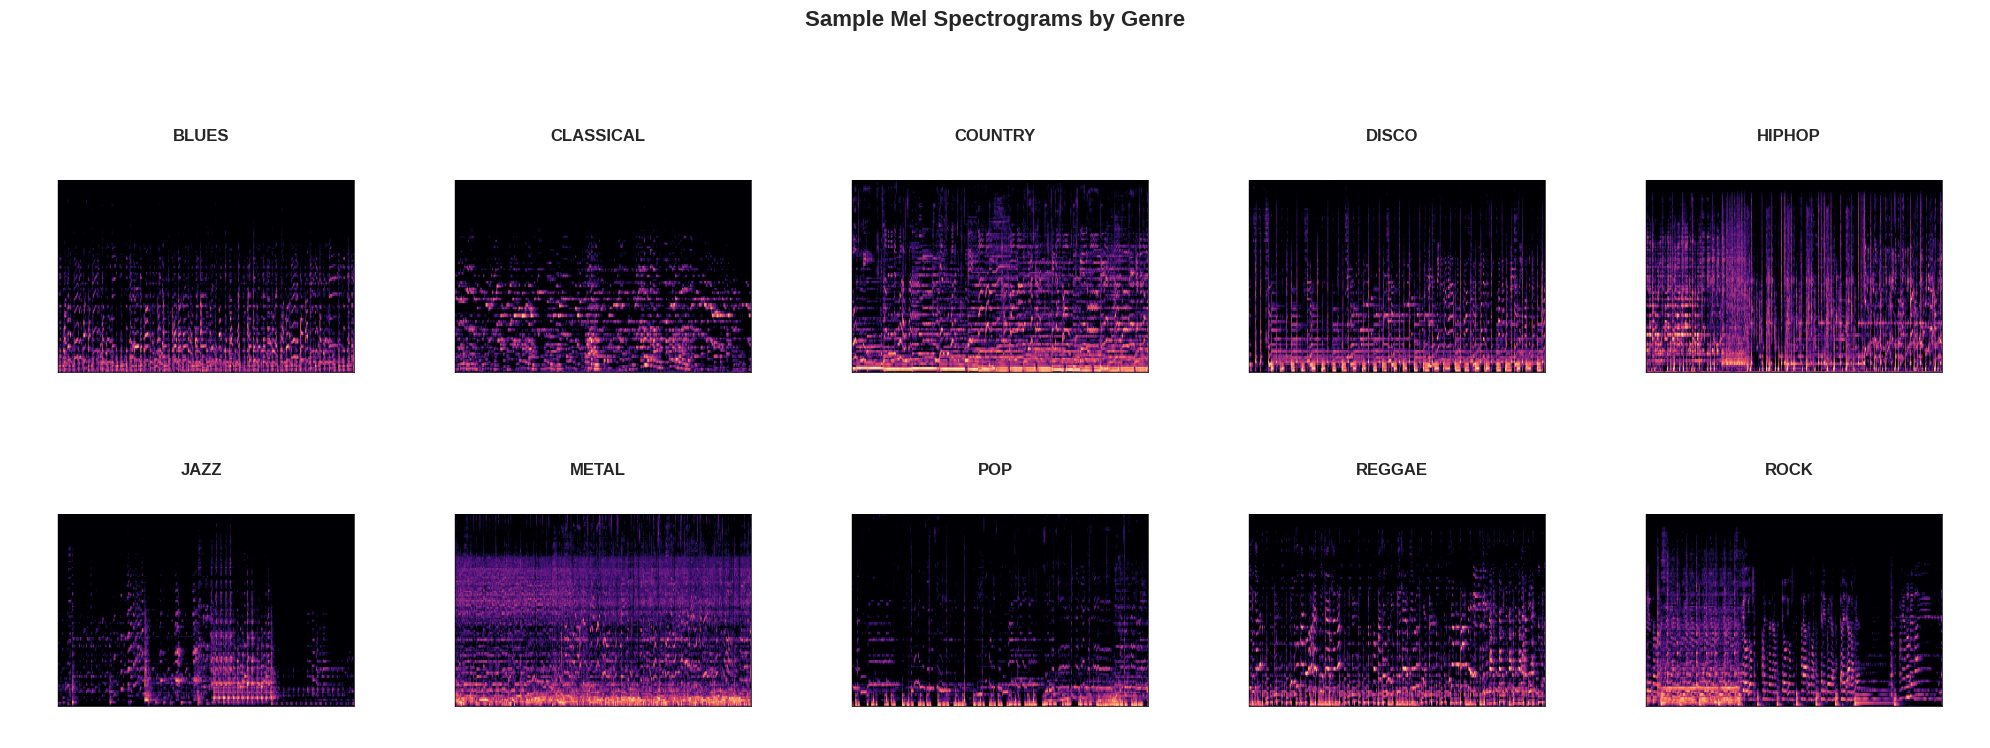


📷 Image dimensions: (288, 432, 3)


In [37]:
# Display sample spectrogram images from each genre
from tensorflow.keras.preprocessing.image import load_img

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, genre in enumerate(genres):
    genre_path = IMAGES_DIR / genre
    # Get first image from each genre
    img_files = sorted(os.listdir(genre_path))
    if img_files:
        img_path = genre_path / img_files[0]
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{genre.upper()}', fontsize=12, fontweight='bold')
        axes[i].axis('off')

plt.suptitle('Sample Mel Spectrograms by Genre', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Get image dimensions
sample_img = load_img(IMAGES_DIR / 'blues' / os.listdir(IMAGES_DIR / 'blues')[0])
print(f"\n📷 Image dimensions: {np.array(sample_img).shape}")

---

# Part 1: Tabular Machine Learning Approach

Using pre-extracted audio features (MFCCs, spectral features, etc.) for classification.

## 3. Data Preprocessing

In [38]:
# Prepare features and target
# Drop non-feature columns
drop_cols = ['filename', 'label', 'length']
X = df_30.drop(columns=drop_cols)
y = df_30['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("=" * 60)
print("📊 Data Preparation")
print("=" * 60)
print(f"Features shape: {X.shape}")
print(f"Target classes: {label_encoder.classes_}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist())

📊 Data Preparation
Features shape: (1000, 57)
Target classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']

Feature columns (57):
['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 

In [39]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Features scaled using StandardScaler")

Training set: 800 samples
Test set: 200 samples

✅ Features scaled using StandardScaler


## 4. Model Training & Evaluation

In [40]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(kernel='rbf', random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

# Store results
results = []

print("=" * 60)
print("🔄 Training Multiple Models...")
print("=" * 60)

for name, model in models.items():
    print(f"\n▶ Training {name}...")

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })

    print(f"   Accuracy: {accuracy:.4f} | F1: {f1:.4f} | CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Results DataFrame
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print("\n" + "=" * 60)
print("📊 Model Comparison Summary")
print("=" * 60)
results_df

🔄 Training Multiple Models...

▶ Training Logistic Regression...
   Accuracy: 0.7100 | F1: 0.7107 | CV: 0.7050 (+/- 0.0363)

▶ Training K-Nearest Neighbors...
   Accuracy: 0.6700 | F1: 0.6695 | CV: 0.6625 (+/- 0.0435)

▶ Training Support Vector Machine...
   Accuracy: 0.7350 | F1: 0.7340 | CV: 0.7075 (+/- 0.0297)

▶ Training Random Forest...
   Accuracy: 0.6850 | F1: 0.6756 | CV: 0.6900 (+/- 0.0527)

▶ Training Gradient Boosting...
   Accuracy: 0.6900 | F1: 0.6902 | CV: 0.6813 (+/- 0.0288)

📊 Model Comparison Summary


,Model,Accuracy,F1 Score,CV Mean,CV Std
2,Support Vector Machine,0.735,0.734019,0.70750,0.029686
0,Logistic Regression,0.710,0.710735,0.70500,0.036315
4,Gradient Boosting,0.690,0.690184,0.68125,0.028777
3,Random Forest,0.685,0.675566,0.69000,0.052678
1,K-Nearest Neighbors,0.670,0.669476,0.66250,0.043481


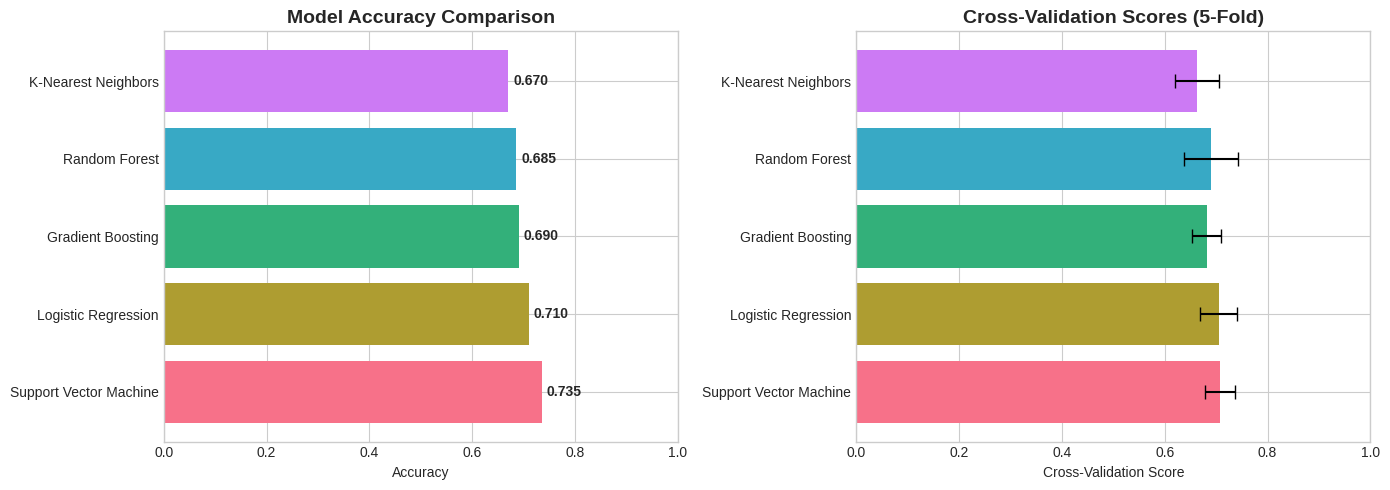

In [41]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
colors = sns.color_palette('husl', n_colors=len(results_df))
bars = axes[0].barh(results_df['Model'], results_df['Accuracy'], color=colors)
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
for bar, acc in zip(bars, results_df['Accuracy']):
    axes[0].text(acc + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{acc:.3f}', va='center', fontweight='bold')

# Cross-validation scores with error bars
axes[1].barh(results_df['Model'], results_df['CV Mean'],
             xerr=results_df['CV Std'], color=colors, capsize=5)
axes[1].set_xlabel('Cross-Validation Score')
axes[1].set_title('Cross-Validation Scores (5-Fold)', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

### 4.1 Best Model Analysis

In [42]:
# Get best model based on accuracy
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print("\n" + "=" * 60)
print("📋 Classification Report")
print("=" * 60)

y_pred_best = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_best,
                           target_names=label_encoder.classes_))

🏆 Best Model: Support Vector Machine

📋 Classification Report
              precision    recall  f1-score   support

       blues       0.82      0.70      0.76        20
   classical       0.95      1.00      0.98        20
     country       0.83      0.75      0.79        20
       disco       0.59      0.50      0.54        20
      hiphop       0.71      0.75      0.73        20
        jazz       0.71      0.85      0.77        20
       metal       0.80      0.80      0.80        20
         pop       0.78      0.70      0.74        20
      reggae       0.61      0.70      0.65        20
        rock       0.57      0.60      0.59        20

    accuracy                           0.73       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.74      0.73      0.73       200



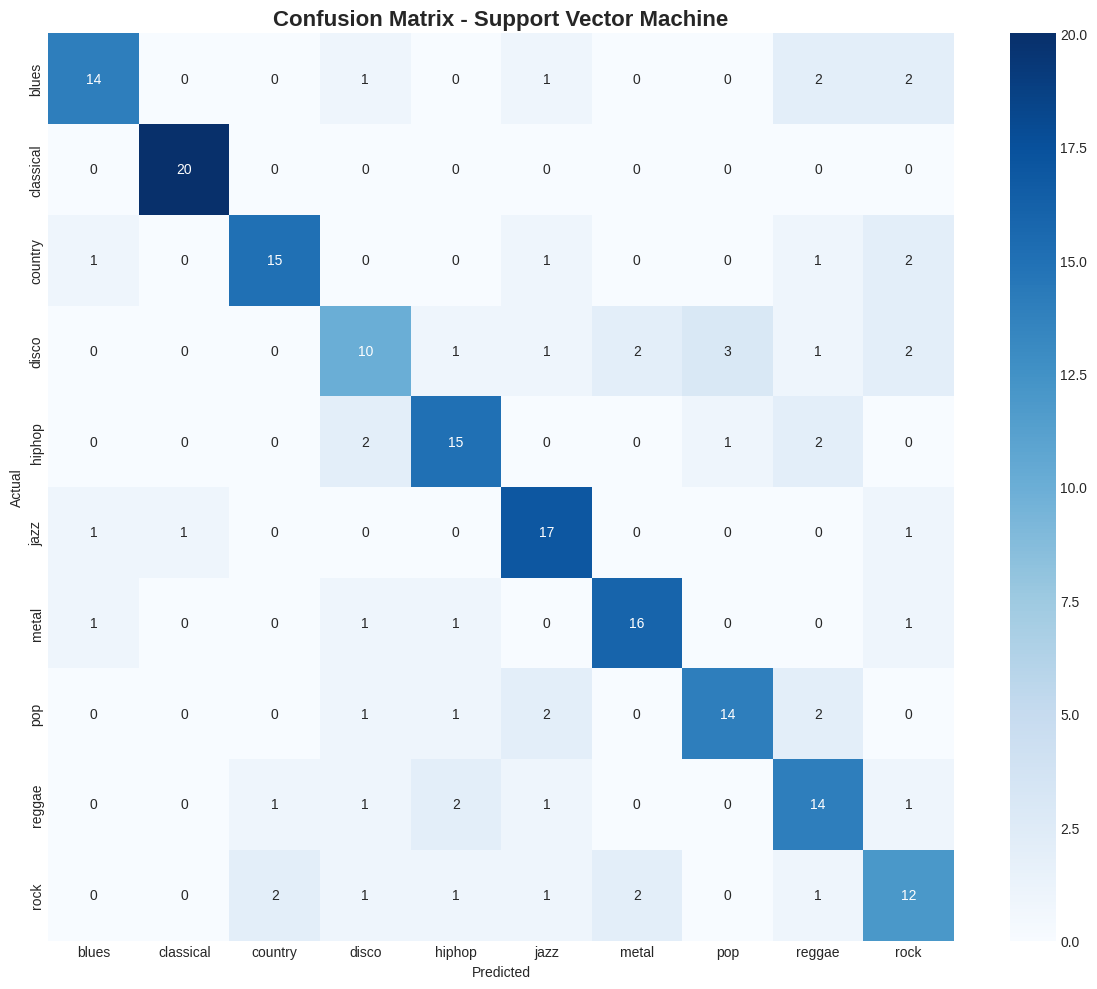

In [43]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### 4.2 Feature Importance (Random Forest)

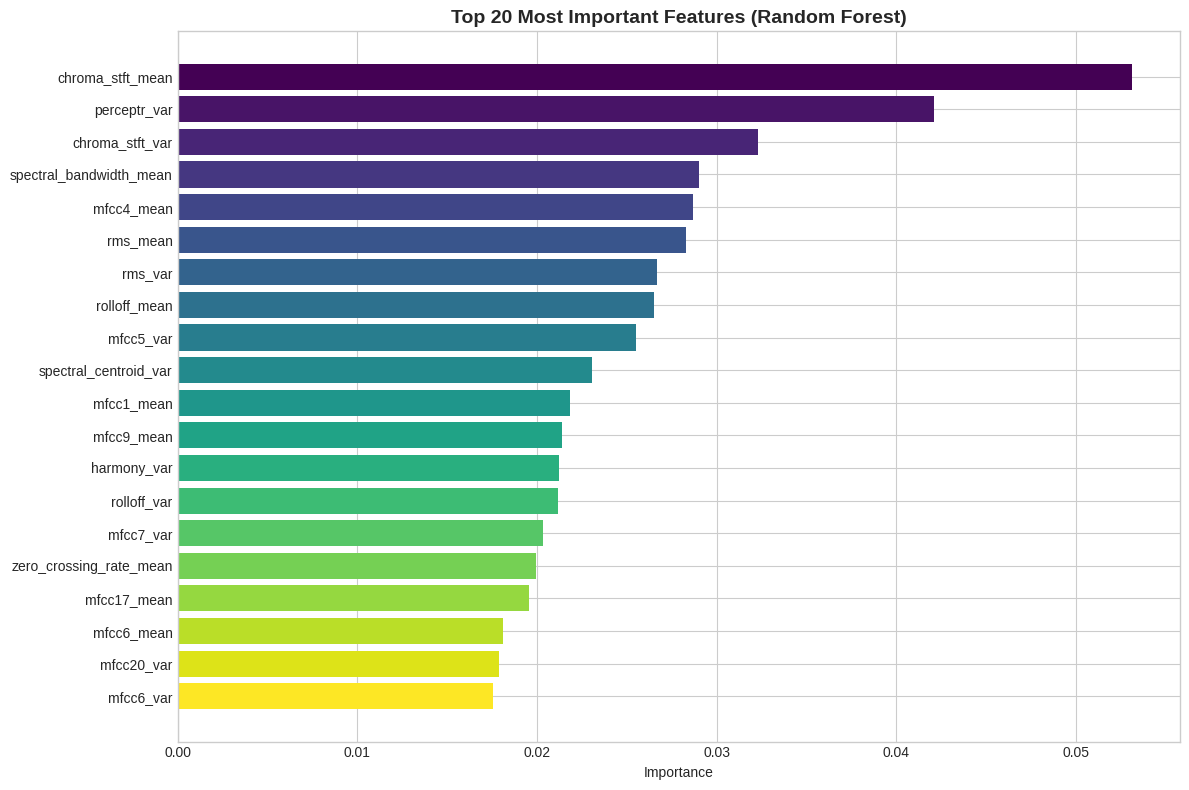


📊 Top 10 Features:
                feature  importance
       chroma_stft_mean    0.053135
           perceptr_var    0.042121
        chroma_stft_var    0.032322
spectral_bandwidth_mean    0.028999
             mfcc4_mean    0.028667
               rms_mean    0.028322
                rms_var    0.026670
           rolloff_mean    0.026520
              mfcc5_var    0.025503
  spectral_centroid_var    0.023039


In [44]:
# Feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features:")
print(feature_importance.head(10).to_string(index=False))